In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from sklearn import linear_model, metrics
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import r2_score
import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option( "display.max_rows" ,250)

In [2]:
churn_data=pd.read_csv('telecom_churn_data.csv')
churn_desc=pd.read_excel('Data+Dictionary-+Telecom+Churn+Case+Study.xlsx')

In [3]:
churn_desc

,Acronyms,Descriptions
0,MOBILE_NUMBER,Customer phone number
1,CIRCLE_ID,Telecom circle area to which the customer belo...
2,LOC,Local calls - within same telecom circle
3,STD,STD calls - outside the calling circle
4,IC,Incoming calls
5,OG,Outgoing calls
6,T2T,"Operator T to T, i.e. within same operator (mo..."
7,T2M,Operator T to other operator mobile
8,T2O,Operator T to other operator fixed line
9,T2F,Operator T to fixed lines of T


# Data analysis and cleaning

In [4]:
churn_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

In [5]:
# Lets look at the size of data
churn_data.shape

(99999, 226)

In [6]:
# Lets look at some rows of the data
churn_data.head(10)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.00,0.00,0.00,0.00
5,7000286308,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,50.258,...,0,NaN,NaN,NaN,NaN,1471,0.00,0.00,0.00,0.00
6,7001051193,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,429.023,...,0,NaN,NaN,NaN,NaN,1673,0.00,0.00,0.00,0.00
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,0,NaN,NaN,NaN,NaN,802,57.74,19.38,18.74,0.00
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,0,NaN,1.0,1.0,NaN,315,21.03,910.65,122.16,0.00
9,7001864400,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,119.518,...,0,NaN,1.0,NaN,NaN,902,0.00,0.00,0.00,0.00


In [7]:
# Lets look at null values
churn_data.isnull().sum()/len(churn_data)

mobile_number               0.000000
circle_id                   0.000000
loc_og_t2o_mou              0.010180
std_og_t2o_mou              0.010180
loc_ic_t2o_mou              0.010180
last_date_of_month_6        0.000000
last_date_of_month_7        0.006010
last_date_of_month_8        0.011000
last_date_of_month_9        0.016590
arpu_6                      0.000000
arpu_7                      0.000000
arpu_8                      0.000000
arpu_9                      0.000000
onnet_mou_6                 0.039370
onnet_mou_7                 0.038590
onnet_mou_8                 0.053781
onnet_mou_9                 0.077451
offnet_mou_6                0.039370
offnet_mou_7                0.038590
offnet_mou_8                0.053781
offnet_mou_9                0.077451
roam_ic_mou_6               0.039370
roam_ic_mou_7               0.038590
roam_ic_mou_8               0.053781
roam_ic_mou_9               0.077451
roam_og_mou_6               0.039370
roam_og_mou_7               0.038590
r

In [8]:
# too many columns so lets look at the ones with significant missing values say more than 50%
round(churn_data.isnull().sum()/len(churn_data.index),2)[round(churn_data.isnull().sum()/len(churn_data.index),2).values>0.5]

date_of_last_rech_data_6    0.75
date_of_last_rech_data_7    0.74
date_of_last_rech_data_8    0.74
date_of_last_rech_data_9    0.74
total_rech_data_6           0.75
total_rech_data_7           0.74
total_rech_data_8           0.74
total_rech_data_9           0.74
max_rech_data_6             0.75
max_rech_data_7             0.74
max_rech_data_8             0.74
max_rech_data_9             0.74
count_rech_2g_6             0.75
count_rech_2g_7             0.74
count_rech_2g_8             0.74
count_rech_2g_9             0.74
count_rech_3g_6             0.75
count_rech_3g_7             0.74
count_rech_3g_8             0.74
count_rech_3g_9             0.74
av_rech_amt_data_6          0.75
av_rech_amt_data_7          0.74
av_rech_amt_data_8          0.74
av_rech_amt_data_9          0.74
arpu_3g_6                   0.75
arpu_3g_7                   0.74
arpu_3g_8                   0.74
arpu_3g_9                   0.74
arpu_2g_6                   0.75
arpu_2g_7                   0.74
arpu_2g_8 

In [9]:
#Imputing missing values for total and average rech_amt since a missing value most probably means that a recharge was not done
rech_cols_list=['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9']
for col in rech_cols_list:
    churn_data[col].fillna(0,inplace=True)

In [10]:
# lets fill missing values in categorical columns with -1
category_cols =  ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9','night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9','fb_user_6','fb_user_7','fb_user_8','fb_user_9']
churn_data[category_cols] = churn_data[category_cols].apply(lambda x: x.fillna(-1))

In [11]:
#Lets create dummy variables for these categorical variables as well
dummy_cols = pd.get_dummies(category_cols,drop_first=True)
churn_data = pd.concat([churn_data,dummy_cols],axis='columns')
churn_data = churn_data.drop(category_cols,axis='columns')

lets drop the columns with a lot of missing data >50% since they will not contribute much to the model

In [12]:
#create a list to use in the drop function
z=list(round(churn_data.isnull().sum()/len(churn_data.index),2)[round(churn_data.isnull().sum()/len(churn_data.index),2).values>0.5].index)
z

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'count_rech_3g_9',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_3g_9',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_2g_9']

In [13]:
churn_data=churn_data.drop(z,axis=1)

In [14]:
# lets check columns for redundant values
unique_value = churn_data.astype('object').describe(include='all').loc['unique', :]
unique_value

mobile_number             99999
circle_id                     1
loc_og_t2o_mou              1.0
std_og_t2o_mou              1.0
loc_ic_t2o_mou              1.0
last_date_of_month_6          1
last_date_of_month_7          1
last_date_of_month_8          1
last_date_of_month_9          1
arpu_6                  85681.0
arpu_7                  85308.0
arpu_8                  83615.0
arpu_9                  79937.0
onnet_mou_6             24313.0
onnet_mou_7             24336.0
onnet_mou_8             24089.0
onnet_mou_9             23565.0
offnet_mou_6            31140.0
offnet_mou_7            31023.0
offnet_mou_8            30908.0
offnet_mou_9            30077.0
roam_ic_mou_6            6512.0
roam_ic_mou_7            5230.0
roam_ic_mou_8            5315.0
roam_ic_mou_9            4827.0
roam_og_mou_6            8038.0
roam_og_mou_7            6639.0
roam_og_mou_8            6504.0
roam_og_mou_9            5882.0
loc_og_t2t_mou_6        13539.0
loc_og_t2t_mou_7        13411.0
loc_og_t

In [15]:
# lets see the columns with only 1 unique value
unique_value[unique_value.values==1]

circle_id                 1
loc_og_t2o_mou          1.0
std_og_t2o_mou          1.0
loc_ic_t2o_mou          1.0
last_date_of_month_6      1
last_date_of_month_7      1
last_date_of_month_8      1
last_date_of_month_9      1
std_og_t2c_mou_6        1.0
std_og_t2c_mou_7        1.0
std_og_t2c_mou_8        1.0
std_og_t2c_mou_9        1.0
std_ic_t2o_mou_6        1.0
std_ic_t2o_mou_7        1.0
std_ic_t2o_mou_8        1.0
std_ic_t2o_mou_9        1.0
Name: unique, dtype: object

There are some columns with only one type of value , lets remove them since it wont be of use to the model

In [16]:
z=list(unique_value[unique_value.values==1].index)
churn_data=churn_data.drop(z,axis=1)

In [17]:
# Lets calculate total recharge amount for a month using the following
# data = total_rech_data * av_rech_amt_data
# voice = total_rech_amt
# total = data + voice
churn_data['total_rech_6'] = churn_data['total_rech_data_6'] * churn_data['av_rech_amt_data_6'] + churn_data['total_rech_amt_6']
churn_data['total_rech_7'] = churn_data['total_rech_data_7'] * churn_data['av_rech_amt_data_7'] + churn_data['total_rech_amt_7']+ churn_data['total_rech_amt_6']
churn_data['total_rech_8'] = churn_data['total_rech_data_8'] * churn_data['av_rech_amt_data_8'] + churn_data['total_rech_amt_8']
churn_data['total_rech_9'] = churn_data['total_rech_data_9'] * churn_data['av_rech_amt_data_9'] + churn_data['total_rech_amt_9']

In [18]:
# Lets drop these
churn_data.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9'
         ,'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9']
       , axis=1, inplace=True)

In [19]:
churn_data.shape

(99999, 166)

In [20]:
# Lets identify high value customers using the 70% percentile in average recharge amount over the first two months
# since that period is considered as good phase

avg_amt =(churn_data.total_rech_6 + churn_data.total_rech_7)/2
high_value_cutoff = np.percentile(avg_amt,70.0)

final_churn_data = churn_data[avg_amt > high_value_cutoff]
final_churn_data.shape

(29976, 166)

In [21]:
# Now lets seperate users into churn and not churn using the data for the last month
final_churn_data['usage_9'] = final_churn_data['total_og_mou_9'] + final_churn_data['total_ic_mou_9'] + final_churn_data['vol_2g_mb_9'] + final_churn_data['vol_3g_mb_9']
final_churn_data['churn'] = np.where(final_churn_data['usage_9']== 0, 1, 0)
final_churn_data['churn'].value_counts()

0    27350
1     2626
Name: churn, dtype: int64

In [22]:
missing_cols = final_churn_data.columns[final_churn_data.isnull().sum()>0]
for col in missing_cols:
    final_churn_data[col].fillna((final_churn_data[col].median()), inplace=True)

In [23]:
262600/27350
# the data is heavily imbalanced as the people who churned consist of only 9.6% of total data

9.60146252285192

In [24]:
# lets drop all columns having _9 since they are being used to predict churn
temp_list=[]
for a in final_churn_data:
    if '9' in a :
        temp_list.append(a)
final_churn_data=final_churn_data.drop(temp_list,axis=1)

In [25]:
final_churn_data.shape

(29976, 127)

# Some EDA before training the model

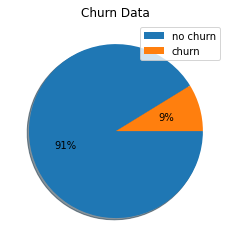

In [26]:
labels=['no churn','churn']
plt.pie(final_churn_data['churn'].value_counts(), autopct='%1.0f%%',counterclock=False, shadow=True)
plt.title('Churn Data')
plt.legend(labels,loc=1)
plt.show()

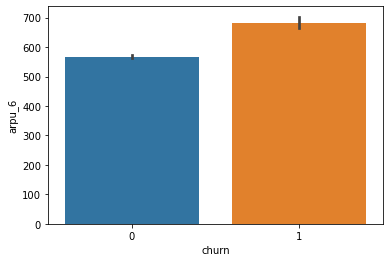

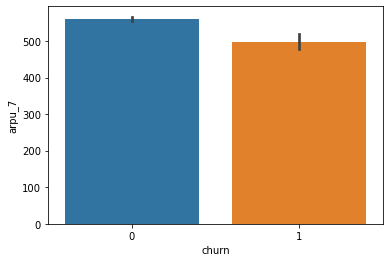

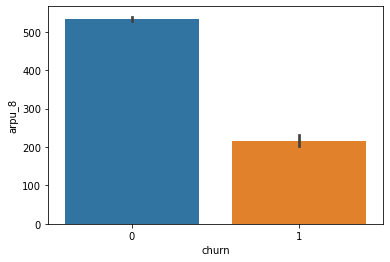

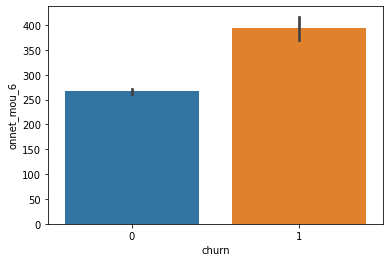

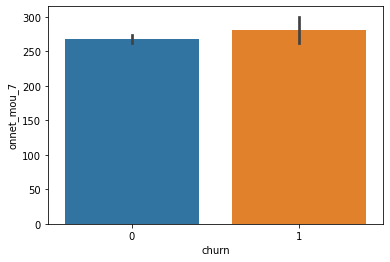

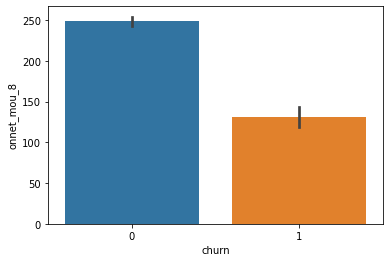

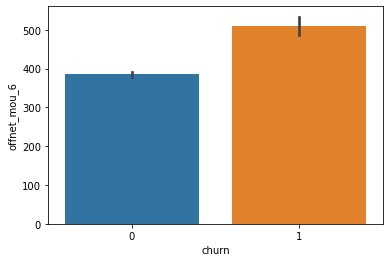

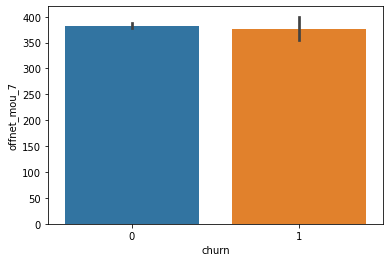

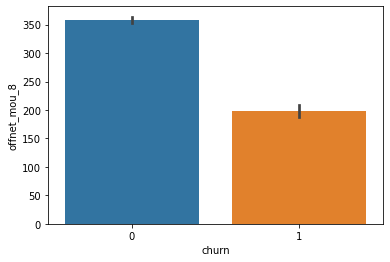

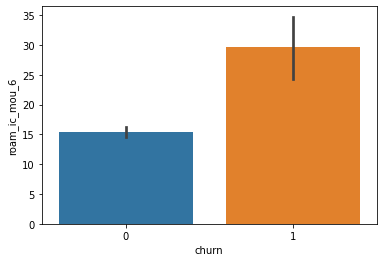

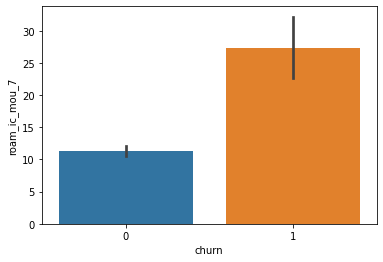

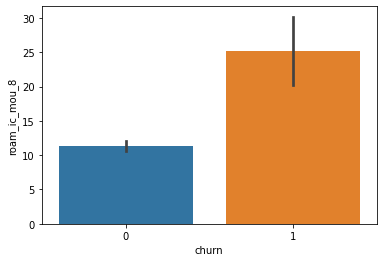

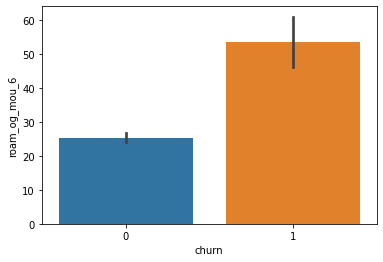

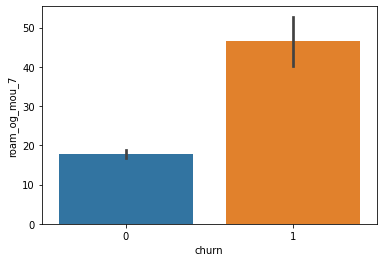

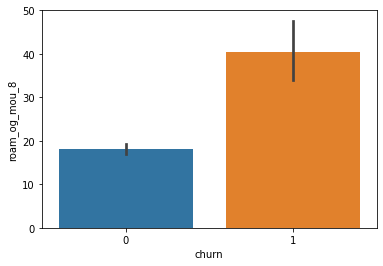

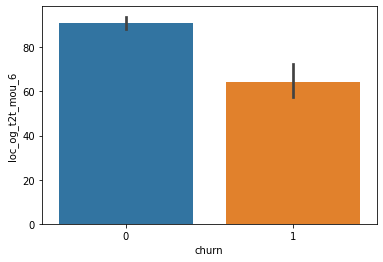

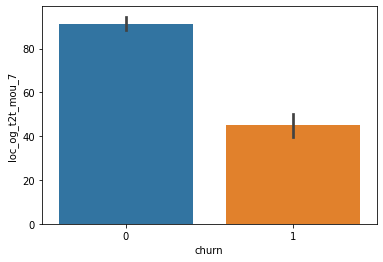

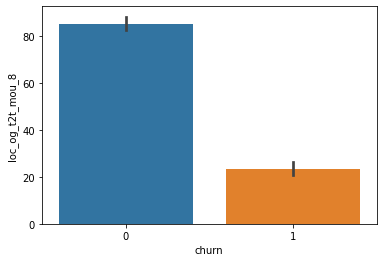

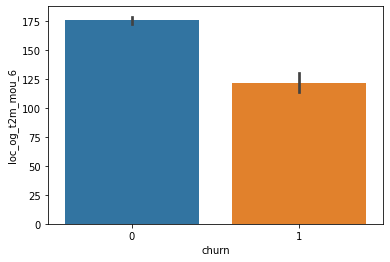

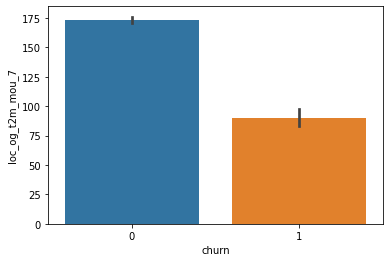

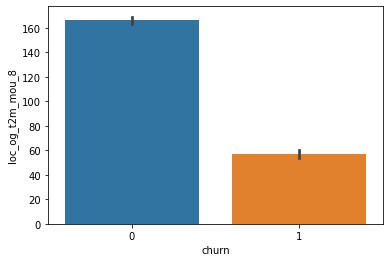

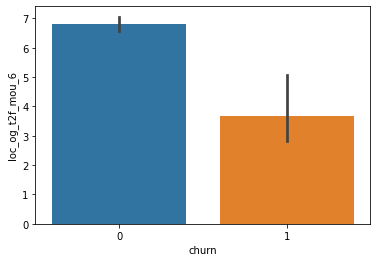

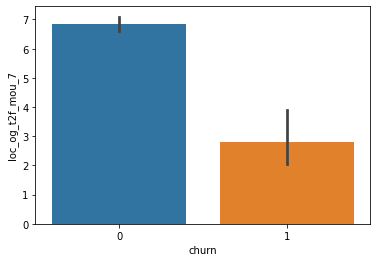

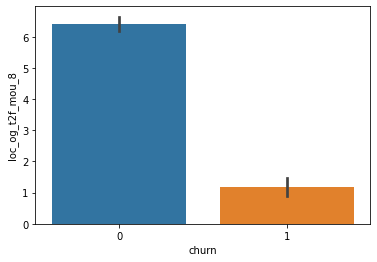

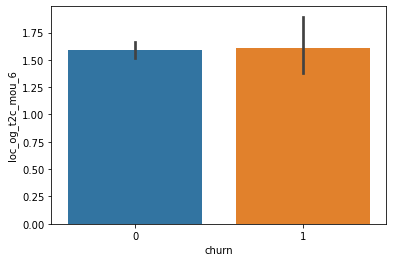

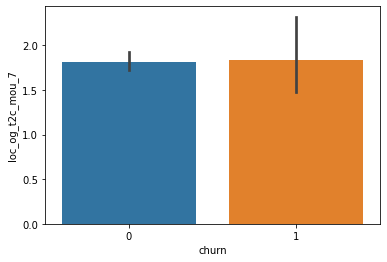

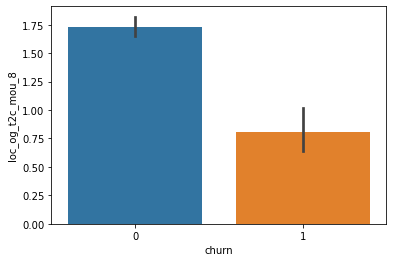

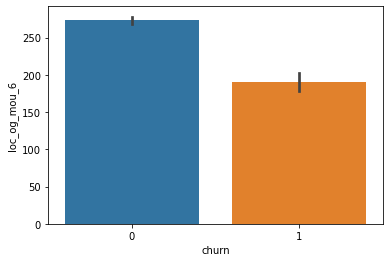

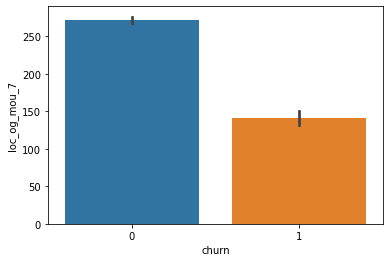

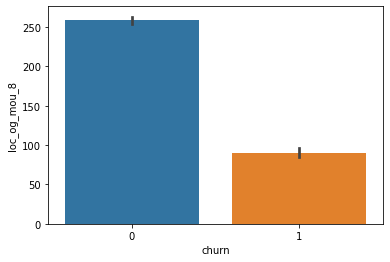

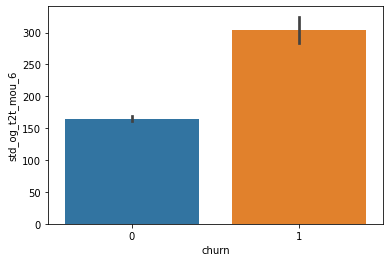

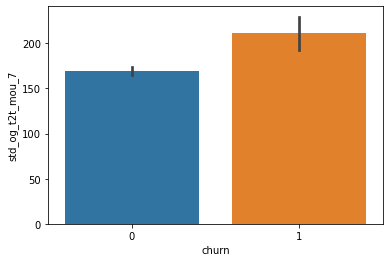

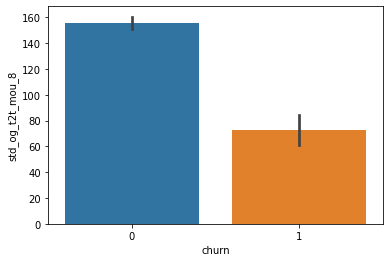

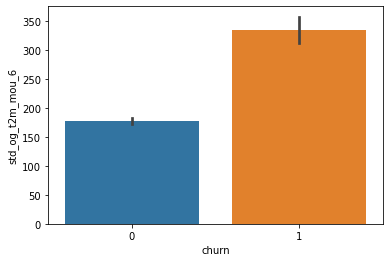

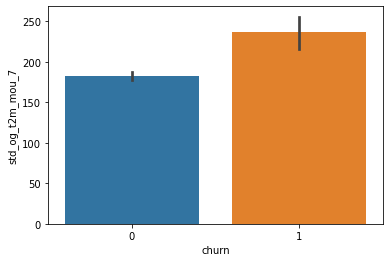

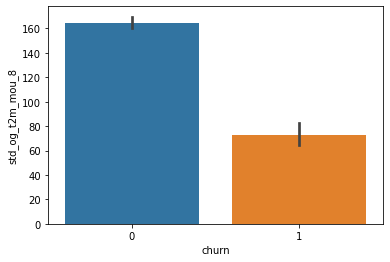

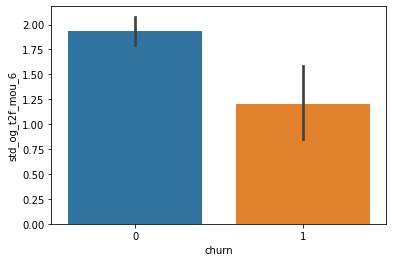

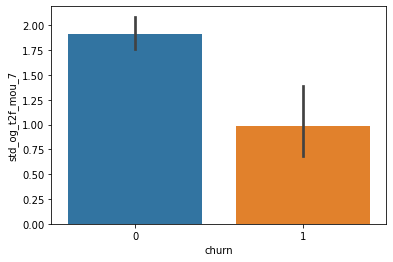

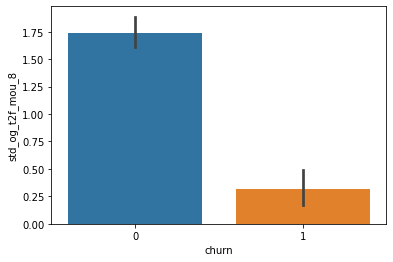

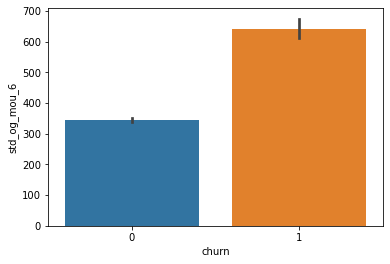

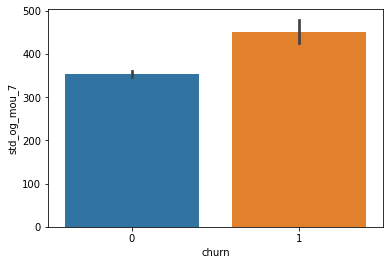

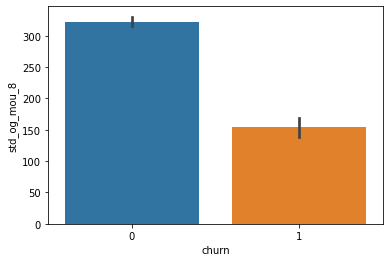

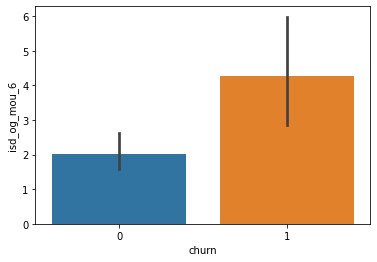

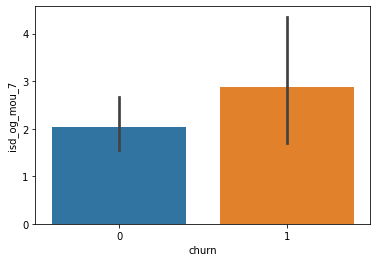

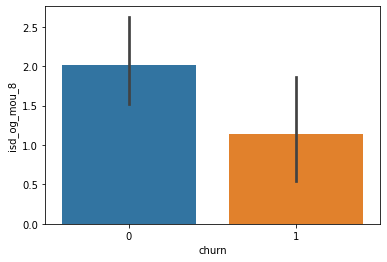

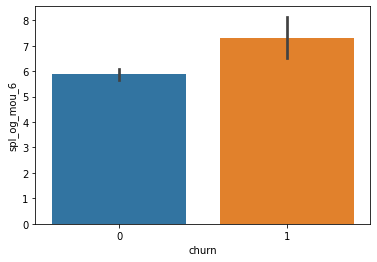

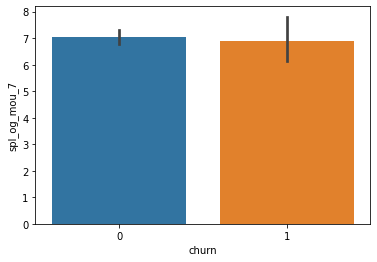

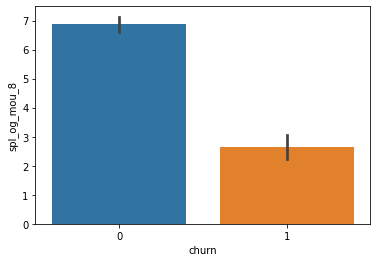

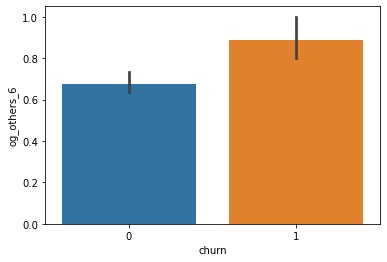

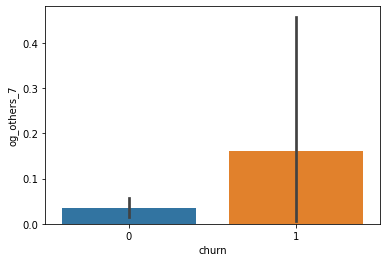

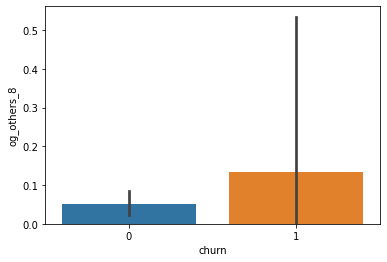

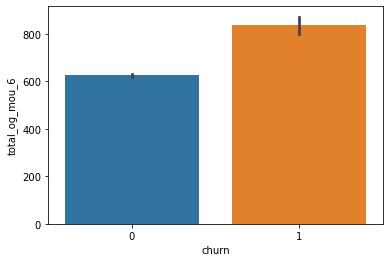

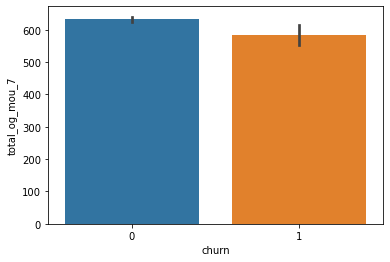

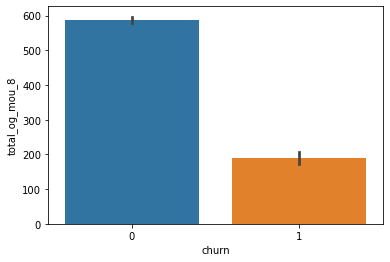

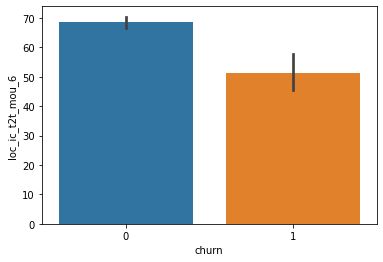

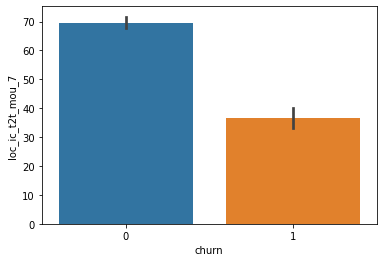

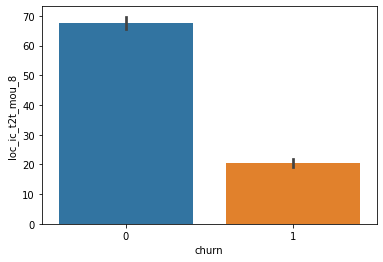

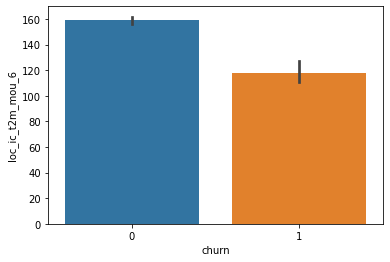

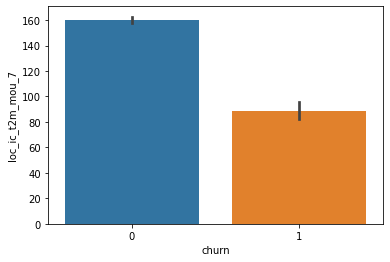

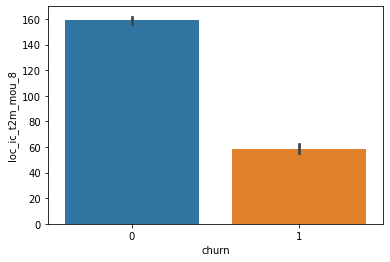

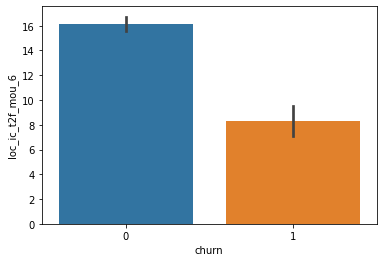

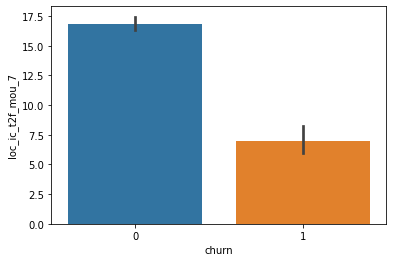

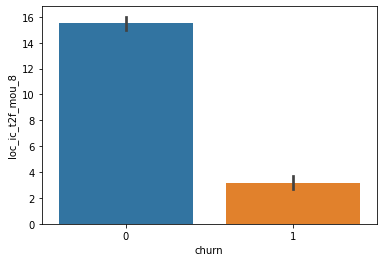

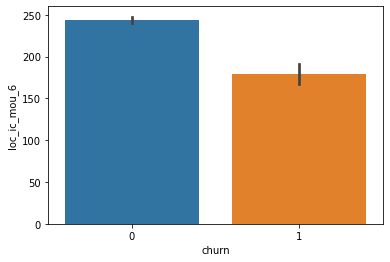

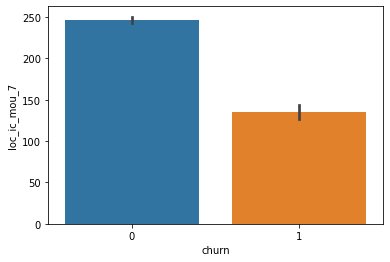

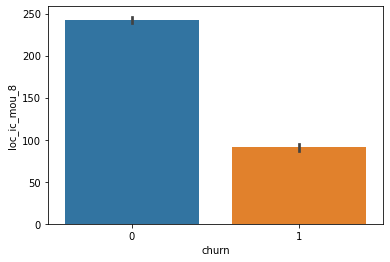

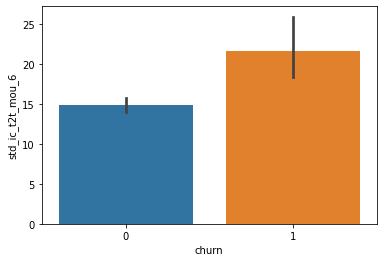

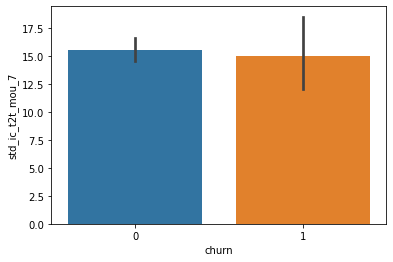

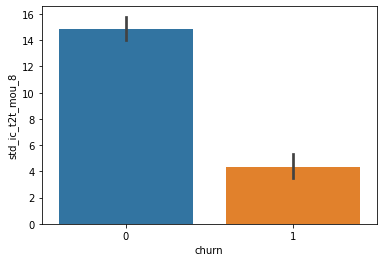

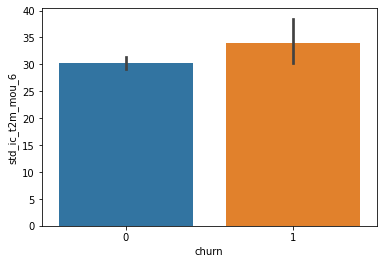

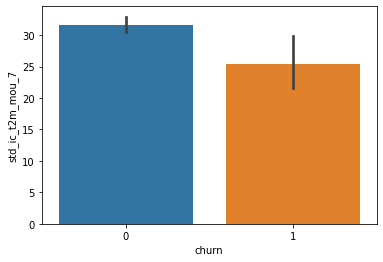

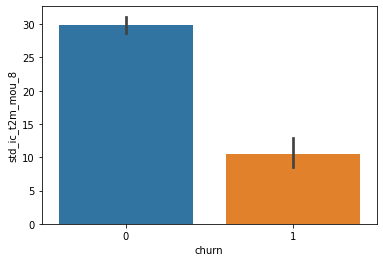

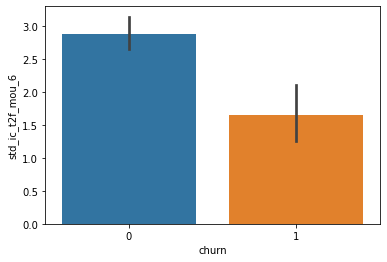

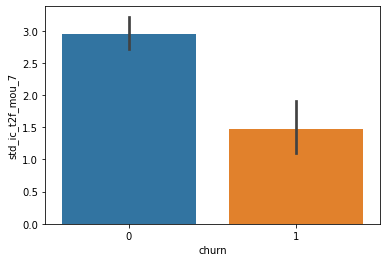

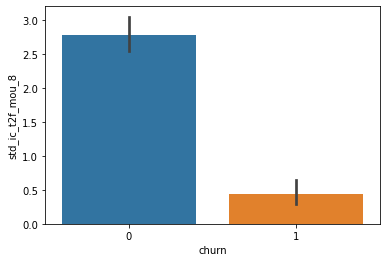

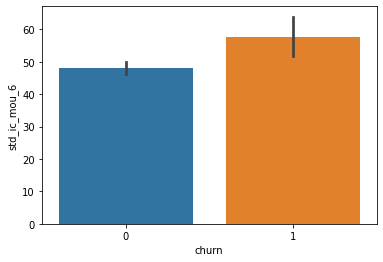

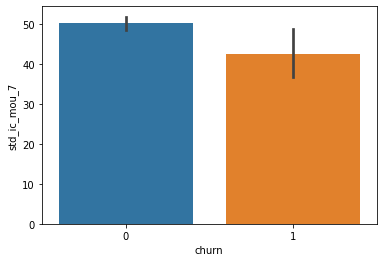

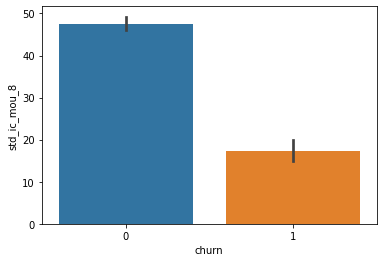

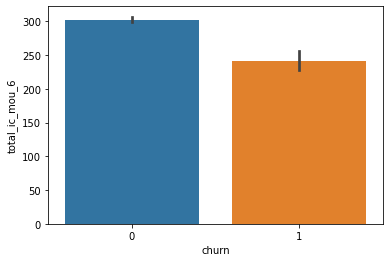

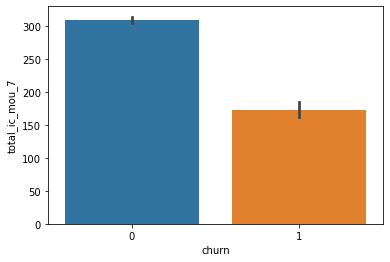

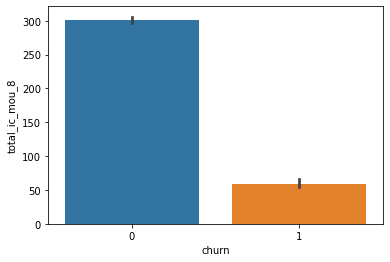

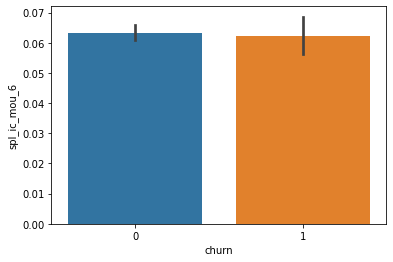

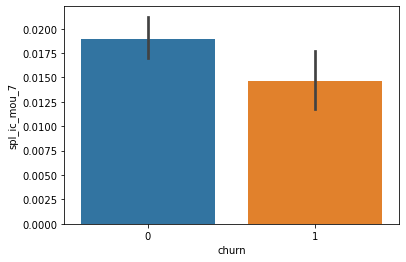

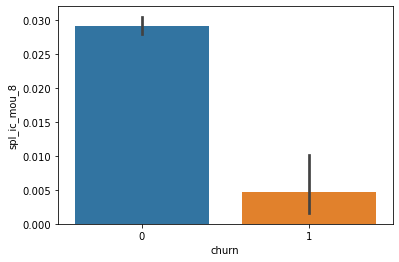

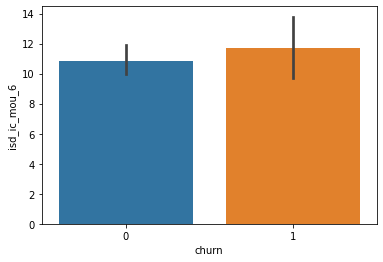

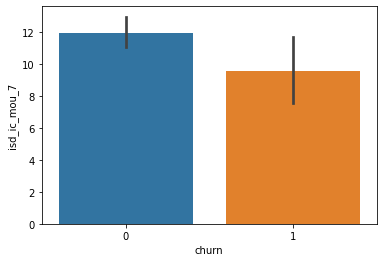

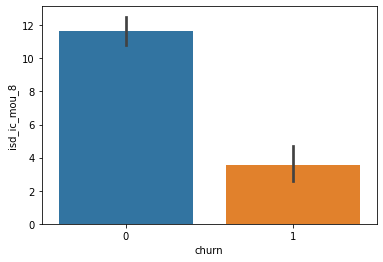

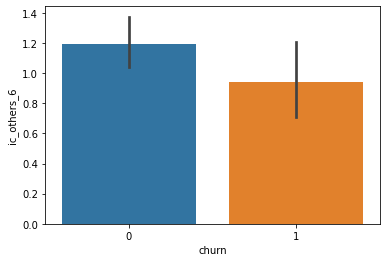

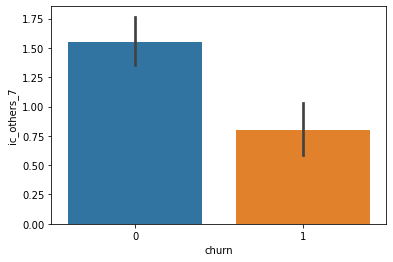

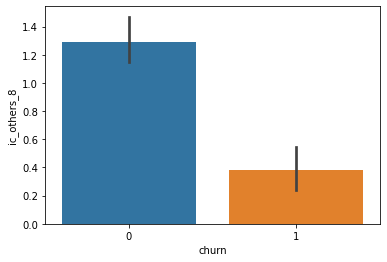

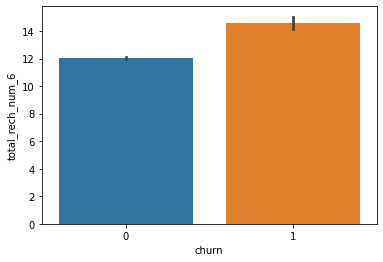

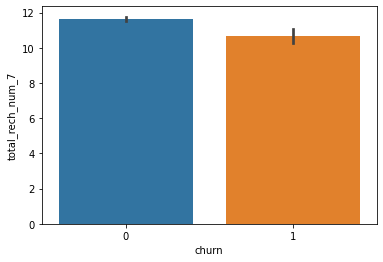

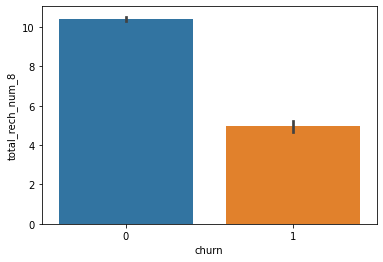

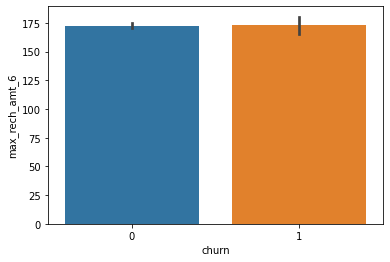

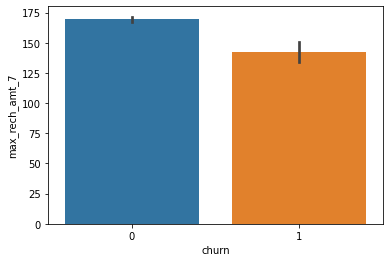

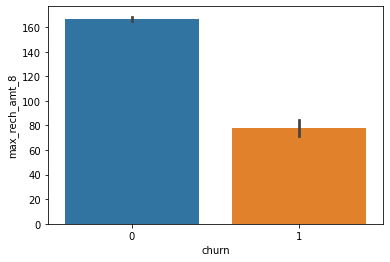

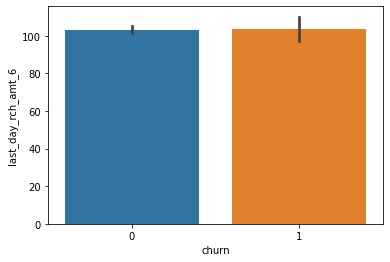

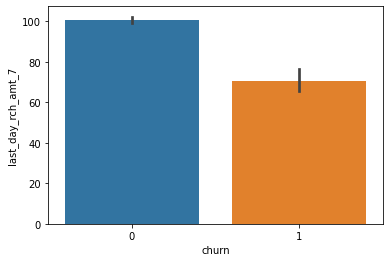

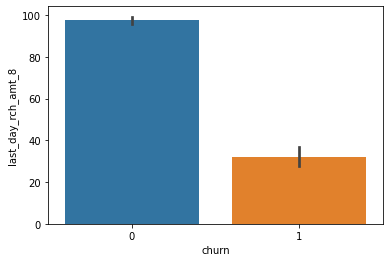

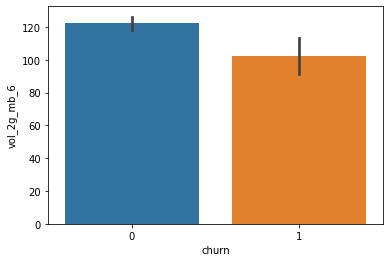

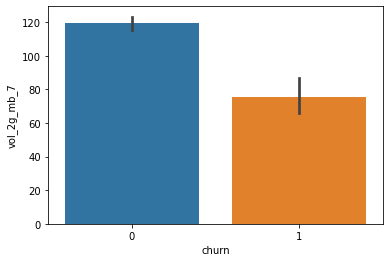

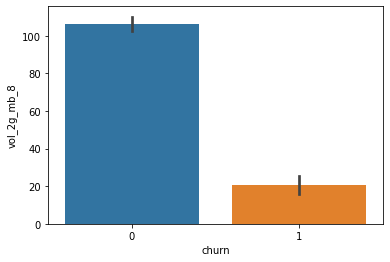

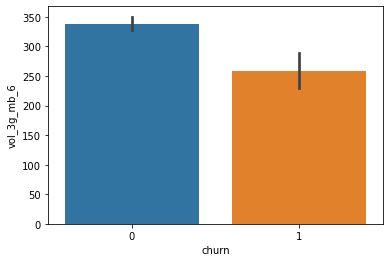

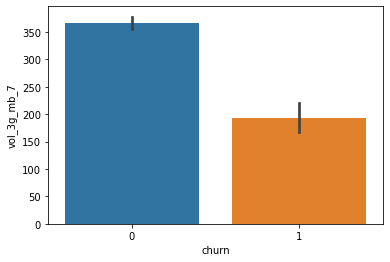

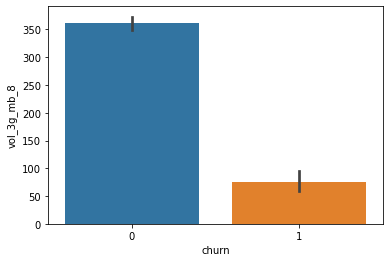

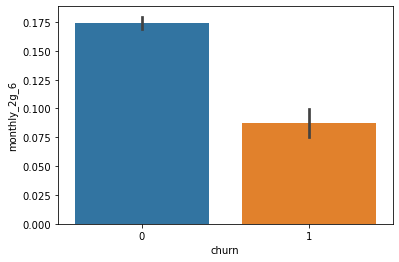

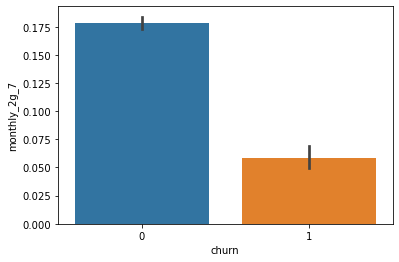

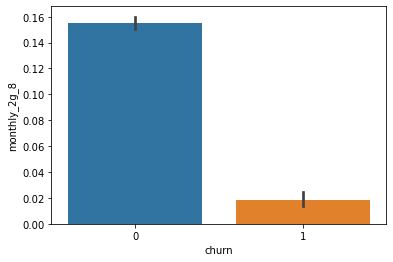

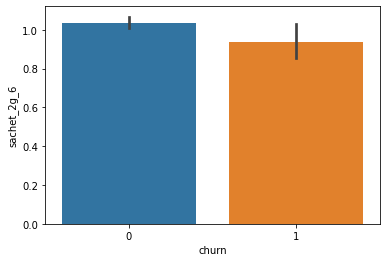

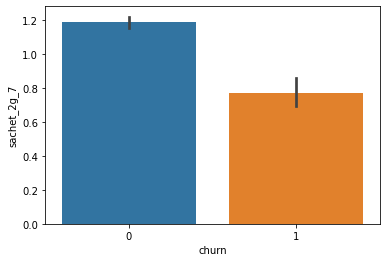

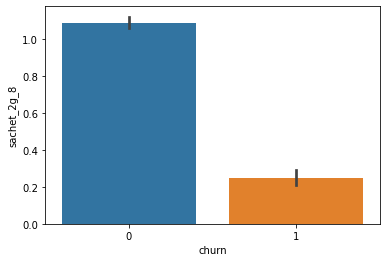

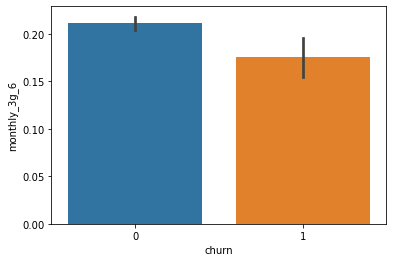

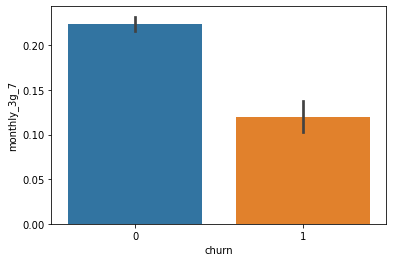

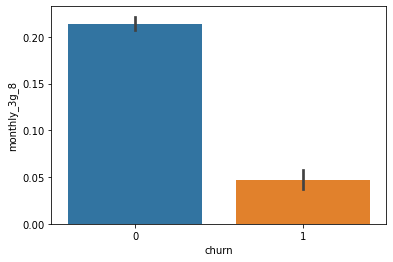

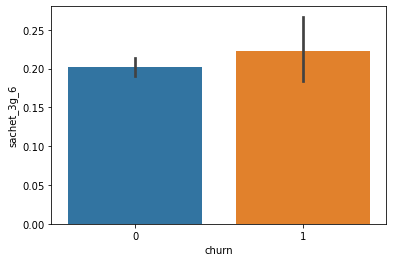

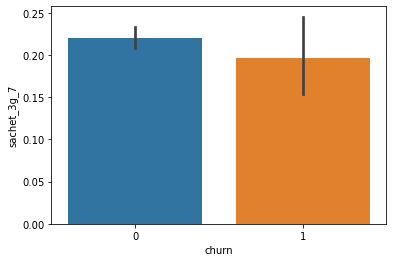

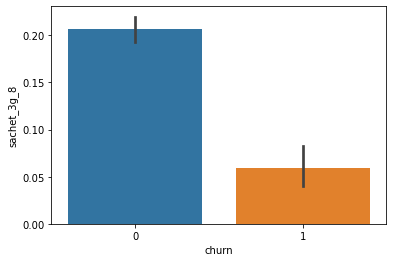

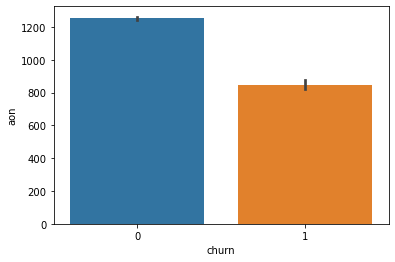

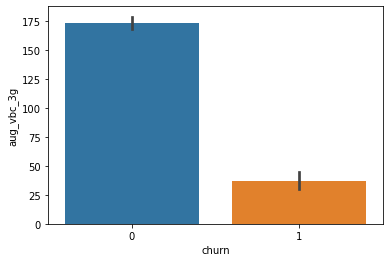

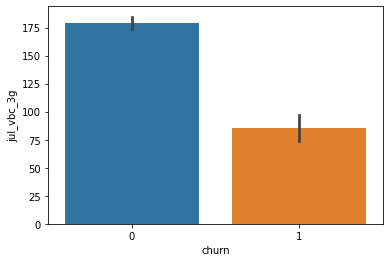

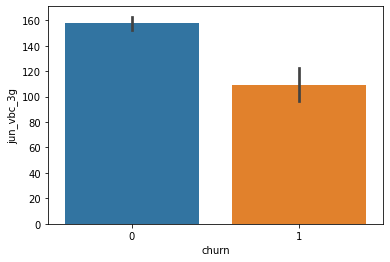

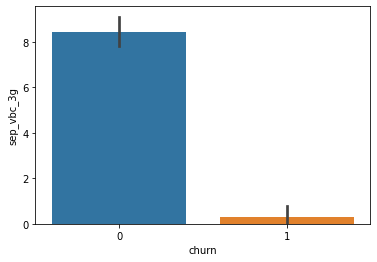

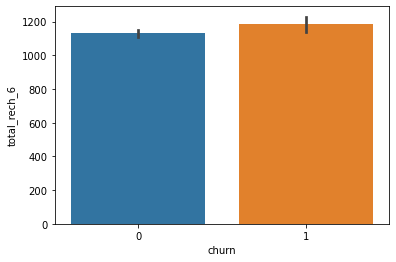

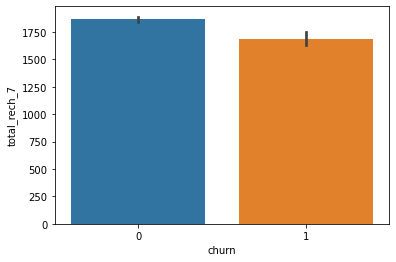

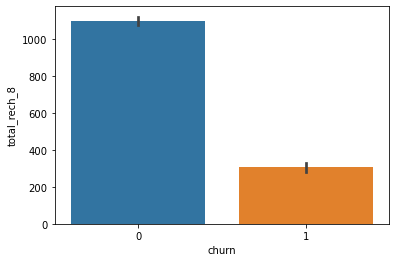

In [27]:
# Lets look at some bivariate bar plots to understand the data
for a in final_churn_data:
    if a in ['churn','mobile_number']:
        continue
    sns.barplot(x='churn', y=a, data=final_churn_data)
    plt.show()

Surprisingly more people with higher arpu (Average Revenue per Unit) for June have churned  
Same for on network , off network , roaming incoming minutes calls in June  
for july and August the trend is expected that higher arpu customers on average are not churning  
Churning customers have a high roaming outgoing minutes for all months  
Other charts  meet expectations

# Lets Move to model building  
class_weight = balanced will be used for training the models since the data is heavily skewed  
it basically means replicating the smaller class until you have as many samples as in the larger one, but in an implicit way

### Preparing data

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Features
X = final_churn_data.drop(['churn','mobile_number'],axis=1)

# Target Variable
y = final_churn_data['churn']


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,test_size=0.3,random_state=38)

In [30]:
# Scaling variables before using PCA
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
#initialize an instance of PCA
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=0)
pca.fit(X_train)

PCA(random_state=0, svd_solver='randomized')

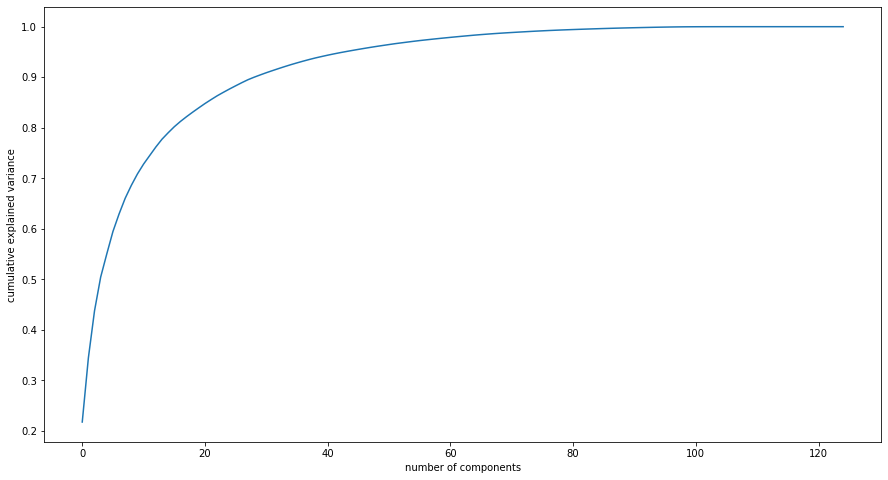

In [32]:
fig = plt.figure(figsize = (15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [33]:
#After using PCA we can see around 40 features are able to explain 95% of the variance
pca.explained_variance_ratio_

array([2.17508975e-01, 1.26987069e-01, 9.30946448e-02, 6.66707917e-02,
       4.60127859e-02, 4.42677099e-02, 3.47538498e-02, 3.11445783e-02,
       2.55226632e-02, 2.26749197e-02, 1.94903045e-02, 1.69823307e-02,
       1.68497985e-02, 1.53810903e-02, 1.26773767e-02, 1.19584792e-02,
       1.04459420e-02, 9.48857671e-03, 8.94811692e-03, 8.60777727e-03,
       8.42226823e-03, 7.81298816e-03, 7.58715409e-03, 6.81648488e-03,
       6.59588060e-03, 6.28175317e-03, 6.18496181e-03, 5.83750874e-03,
       4.95476514e-03, 4.55838589e-03, 4.40401687e-03, 4.13324157e-03,
       4.06075740e-03, 3.92962613e-03, 3.77849488e-03, 3.56033019e-03,
       3.41686792e-03, 3.27467655e-03, 3.06736290e-03, 2.77133656e-03,
       2.68821812e-03, 2.52732117e-03, 2.39295927e-03, 2.26084112e-03,
       2.17781319e-03, 2.11808693e-03, 2.03967620e-03, 2.01652465e-03,
       1.90219649e-03, 1.81465469e-03, 1.79614038e-03, 1.76578099e-03,
       1.57336780e-03, 1.54839823e-03, 1.53799607e-03, 1.46231186e-03,
      

In [34]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=40)
X_train_pca = pca_final.fit_transform(X_train)

In [35]:
X_test_pca = pca_final.transform(X_test)

More importance will be given to the f1 score(harmonic mean of precision and recall) of churners since they represent lost revenue for the operator  

## Lets try a Logistic regression model first

In [36]:
from sklearn.linear_model import LogisticRegression
learner_pca = LogisticRegression(class_weight='balanced')
model_pca = learner_pca.fit(X_train_pca, y_train)

In [37]:
pred_probs_test = model_pca.predict_proba(X_test_pca)

In [65]:
(metrics.roc_auc_score(y_test, pred_probs_test[:,1]))

0.8859859286316449

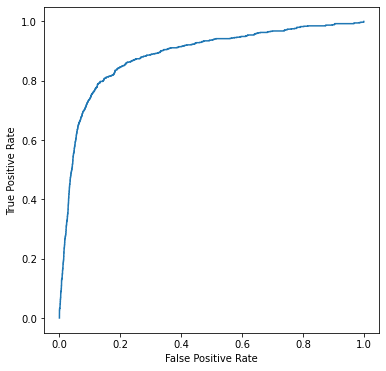

In [39]:
# 
fpr, tpr, thresholds = metrics.roc_curve( y_test, pred_probs_test[:,1],drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, pred_probs_test[:,1] )
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The Curve has almost 0.89 area which is good

In [40]:
# Consolidating y_pred and y_test into a dataframe for convenience
temp = pd.DataFrame(pred_probs_test)
temp = temp.iloc[:,[1]]
temp.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_pred = pd.concat([y_test,temp],axis=1)
y_pred= y_pred.rename(columns={ 1 : 'pred'})

In [42]:
# Lets create a dataframe with churn/non churn prediction using cutoffs at every 0.1 probability
for i in range(11):
    y_pred[i]= y_pred.pred.map( lambda x: 1 if x > i/10 else 0)
y_pred.head()

,churn,pred,0,1,2,3,4,5,6,7,8,9,10
0,0,0.864935,1,1,1,1,1,1,1,1,1,0,0
1,0,0.142288,1,1,0,0,0,0,0,0,0,0,0
2,0,0.181599,1,1,0,0,0,0,0,0,0,0,0
3,0,0.349355,1,1,1,1,0,0,0,0,0,0,0
4,1,0.812997,1,1,1,1,1,1,1,1,1,0,0


In [43]:
from sklearn.metrics import classification_report
for i in range(11):
    print('With Probability cutoff as :',i/10)
    print(classification_report( y_pred.churn, y_pred[i]))

With Probability cutoff as : 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8182
           1       0.09      1.00      0.17       811

    accuracy                           0.09      8993
   macro avg       0.05      0.50      0.08      8993
weighted avg       0.01      0.09      0.01      8993

With Probability cutoff as : 0.1
              precision    recall  f1-score   support

           0       0.99      0.31      0.47      8182
           1       0.12      0.97      0.22       811

    accuracy                           0.36      8993
   macro avg       0.56      0.64      0.34      8993
weighted avg       0.91      0.36      0.44      8993

With Probability cutoff as : 0.2
              precision    recall  f1-score   support

           0       0.99      0.48      0.64      8182
           1       0.15      0.94      0.26       811

    accuracy                           0.52      8993
   macro avg       0.57      

With probability cutoff os 0.7 we get the highest f1 score of 0.57

## Lets check how an SVM with gridsearchCV optimization performs on the data

In [44]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.01, 0.001, 0.0001],'C': [1, 10, 100, 1000]}]

model = SVC(kernel="linear", class_weight='balanced')

model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                       scoring= 'accuracy', 
                       cv = folds, 
                       verbose = 1,n_jobs=-1)
model_cv.fit(X_train_pca,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=SVC(class_weight='balanced', kernel='linear'), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             scoring='accuracy', verbose=1)

In [45]:
model_cv.best_params_

{'C': 1000, 'gamma': 0.01}

In [47]:
from sklearn.metrics import confusion_matrix
model = SVC(C=100, gamma=0.01, kernel="linear", class_weight='balanced')
model.fit(X_train_pca,y_train)
svm_pred = model.predict(X_test_pca)

SVM_matrix=confusion_matrix(y_test,svm_pred)
SVM_matrix

array([[6772, 1410],
       [ 140,  671]], dtype=int64)

In [48]:
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8182
           1       0.32      0.83      0.46       811

    accuracy                           0.83      8993
   macro avg       0.65      0.83      0.68      8993
weighted avg       0.92      0.83      0.86      8993



## After SVMs lets try Decision tree approach with gridsearchCV

In [49]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {
    'max_depth': [5,10,15],
    'min_samples_leaf': [5,10,15,20,25,30,35,40,45,50],
    'min_samples_split': [5,10,15,20,25,30,35,40,45,50],
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, refit='recall_score',
                          cv = n_folds, verbose = 1, n_jobs = -1)

# Fit the grid search to the data
grid_search.fit(X_train_pca,y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.2min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50],
                         'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40,
                                               45, 50]},
             refit='recall_score', verbose=1)

In [50]:
# Lets see best accuracy
grid_search.best_score_

0.8468759972680109

In [51]:
# lets see best estimators
grid_search.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_leaf=5, min_samples_split=10)

In [52]:
# using the best estimators lets create the final tree 
clf = DecisionTreeClassifier(criterion = "entropy",class_weight='balanced',
                                  random_state = 100,
                                  max_depth=15, 
                                  min_samples_leaf=5,
                                  min_samples_split=5)
clf.fit(X_train_pca,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_leaf=5, min_samples_split=5,
                       random_state=100)

In [53]:
tree_pred = clf.predict(X_test_pca)
print(classification_report(y_test,tree_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      8182
           1       0.28      0.52      0.36       811

    accuracy                           0.83      8993
   macro avg       0.61      0.69      0.63      8993
weighted avg       0.89      0.83      0.86      8993



Best F1 score here is 0.36

## Lets checkout random forests algo using gridsearchCV too

In [54]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'max_depth': [8,10],
    'min_samples_leaf': [100,150,200],
    'min_samples_split':[100,200,300,400],
    'n_estimators': [5,10,50,100,150,200], 
    'max_features': [6, 8, 10, 12]
}

rf = RandomForestClassifier(class_weight='balanced')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 5, n_jobs=-1, verbose = 1)

grid_search.fit(X_train_pca, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 35.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10], 'max_features': [6, 8, 10, 12],
                         'min_samples_leaf': [100, 150, 200],
                         'min_samples_split': [100, 200, 300, 400],
                         'n_estimators': [5, 10, 50, 100, 150, 200]},
             refit='recall_score', verbose=1)

In [55]:
# Best score for random forests
grid_search.best_score_

0.8707525894046159

In [56]:
# best estmators used
grid_search.best_params_

{'max_depth': 10,
 'max_features': 6,
 'min_samples_leaf': 100,
 'min_samples_split': 200,
 'n_estimators': 150}

In [57]:
# training random forest using best estimators
clf = RandomForestClassifier(class_weight='balanced',
                                  random_state = 100,
                                  n_estimators = 200,
                                  max_depth=10, 
                                  max_features=6 ,
                                  min_samples_split=100,
                                  min_samples_leaf=100)
clf.fit(X_train_pca,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=6,
                       min_samples_leaf=100, min_samples_split=100,
                       n_estimators=200, random_state=100)

In [58]:
y_pred_default = clf.predict(X_test_pca)
print(classification_report(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      8182
           1       0.39      0.73      0.51       811

    accuracy                           0.87      8993
   macro avg       0.68      0.81      0.72      8993
weighted avg       0.92      0.87      0.89      8993



Best F1 score here is 0.51

Looking at the f1 scores for all models Logistic regression with PCA having a cutoff of 0.7 gives the highest f1 score 0f 0.57  
So that model works best for this data

Lets move onto the second model where we identify driver variables  
Lasso regression is used since it implicitly performs feature selection as well

In [59]:
folds = KFold(n_splits=10,shuffle=True,random_state=42)
params = {'alpha': [0.0000001,0.000001,0.0001, 0.001, 0.01, 0.05, 0.1]}

model = Lasso()
model_cv = GridSearchCV(estimator = model,
                        param_grid=params,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True
                       )
model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   22.8s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1e-07, 1e-06, 0.0001, 0.001, 0.01, 0.05,
                                   0.1]},
             return_train_score=True, scoring='r2', verbose=1)

In [60]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,8.062626,0.658954,0.003603,0.001499,1.000000e-07,{'alpha': 1e-07},0.339024,0.314877,0.271907,0.328989,...,0.327047,0.326517,0.331106,0.332914,0.327235,0.329231,0.329623,0.322853,0.328045,0.002699
1,8.648657,0.923059,0.005102,0.001869,1.000000e-06,{'alpha': 1e-06},0.339216,0.315170,0.274035,0.329363,...,0.327094,0.326590,0.331166,0.332983,0.327291,0.329281,0.329666,0.322931,0.328100,0.002698
2,7.294749,0.972325,0.005401,0.006375,1.000000e-04,{'alpha': 0.0001},0.284087,0.274974,0.278304,0.273570,...,0.270438,0.270694,0.274437,0.277234,0.269872,0.275291,0.274422,0.265672,0.272224,0.003239
3,0.382686,0.025438,0.006403,0.005314,1.000000e-03,{'alpha': 0.001},0.107562,0.103976,0.112134,0.122307,...,0.108351,0.105896,0.109678,0.110528,0.107023,0.111883,0.108561,0.108345,0.108854,0.001606
4,0.255957,0.027156,0.003700,0.000640,1.000000e-02,{'alpha': 0.01},-0.000021,-0.003383,-0.000211,-0.000008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


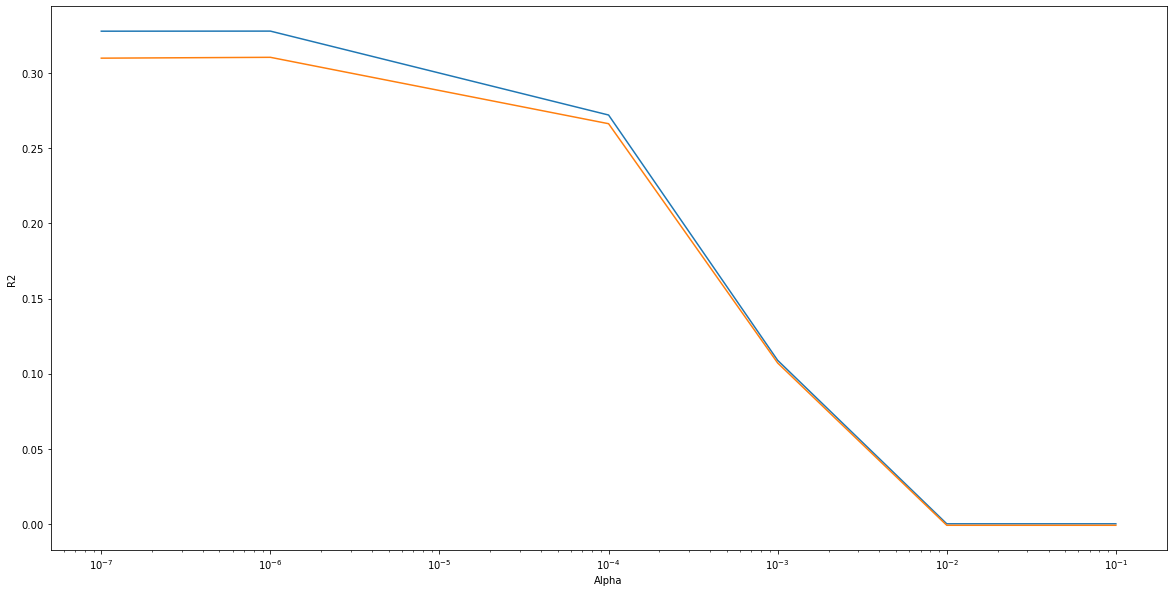

In [61]:
plt.figure(figsize=(20,10))
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2')
plt.xlabel('Alpha')
plt.show()

In [62]:
lasso = Lasso(alpha=0.000001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.3275499682899832
0.3132726431512508


In [63]:
coef_values = list(lasso.coef_)
coef_values.insert(0,lasso.intercept_)
cols = final_churn_data.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,coef_values)))
lasso_coef.columns = ['Featuere','Coef']

In [64]:
lasso_coef.sort_values(by='Coef',ascending=False).head(5)

,Featuere,Coef
9,offnet_mou_8,13.190568
6,onnet_mou_8,11.353839
87,isd_ic_mou_8,10.176085
55,loc_ic_t2t_mou_6,6.460085
66,loc_ic_mou_8,6.047314


### These variables have been identified as most important
> - off network minutes of usage for August  
> - on network minutes of usage for August  
> - incoming isd minutes for August  
> - incoming local call minutes within the same operator for June  
> - incoming local call minutes for August  

# Conclusions derived from data analysis
> People with higher arpu for June have churned a lot  
> Same for on network , off network , roaming incoming minutes calls in June  
> Churning customers have a high roaming outgoing minutes for all months  

Some strategies to retain customers could be :  
>to adjust rates for customers that use the roaming service a lot  
>Talk with business team to identify why customers with high arpu values for June are churning
